#### Nome: Cristiano Moreira Martins
#### Matrícula: 11111871-7

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray
from joblib import dump, load
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


path_images = 'coin_images/train/5-c/'
coin_img = '1-c_2002_10.jpg'

### Implementação

In [18]:
class ImageProcessor:
    def __init__(self, size):
        self.size = size

    # Função para criar descritores de imagens utilizando HOG
    def create_features(self, image_str_img):
        
        # Se a entrada é uma string, assumimos que é um nome de arquivo
        if isinstance(image_str_img, str):
            # Carrega a imagem
            image = imread(image_str_img)
            try:
                image = imread(image_str_img)
            except FileNotFoundError:
                print(f"Arquivo {image_str_img} não encontrado.")
                return None
            except OSError:
                print(f"Erro ao ler o arquivo {image_str_img}.")
                return None
        else:
            image = image_str_img

        # Se a imagem não for em escala de cinza, converte para escala de cinza
        if len(image.shape) > 2:
            image = rgb2gray(image)

        # Redimensiona a imagem para um tamanho fixo
        image = resize(image, self.size)

        # Calcula o descritor HOG para a imagem
        fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)

        return fd

    def process_images(self, dir_name):
        features_dict = {}

        # Para cada arquivo no diretório...
        for file_name in os.listdir(dir_name):

            if (file_name.endswith('.png') or file_name.endswith('.jpg')):

                # Extrai características da imagem
                features = self.create_features(dir_name + file_name)

                if features is None:
                    continue

                # Armazena as características no dicionário com o nome do arquivo como chave
                features_dict[file_name] = features
                
        return features_dict
    
    def detect_coins(self, image, classifier):
        # Converte a imagem para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Suaviza a imagem
        #gray = cv2.medianBlur(gray, 5)

        # Detecta círculos na imagem
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 60, param1=150, param2=250, minRadius=0, maxRadius=0)
        if circles is not None:
            circles = np.uint16(np.around(circles))
        else:
            circles = []

        coinCount = 0
        # Para cada círculo encontrado...
        if len(circles) > 0:
            for i in circles[0,:]:
                # Verifica se o círculo completo está dentro dos limites da imagem
                if i[0]-i[2] >= 0 and i[1]-i[2] >= 0 and i[0]+i[2] <= gray.shape[1] and i[1]+i[2] <= gray.shape[0]:
                    # Obtém a região de interesse da imagem
                    roi = gray[i[1]-i[2]:i[1]+i[2], i[0]-i[2]:i[0]+i[2]]

                    # Verifica se a ROI não está vazia
                    if roi.size > 0:
                        # Redimensiona a região de interesse para o tamanho esperado pelo classificador
                        # Que foi treinado com imagens de tamanho fixo (64x64), (256,256)...
                        roi = cv2.resize(roi, self.size)
                        #cv2.imshow('Coins', image)
                        #print("ROI: ", roi)
                        
                        # Extrai as características da região de interesse
                        features = self.create_features(roi)

                        #print("Features: ", features)

                        # Classifica a região de interesse e extrai o rótulo atribuido pelo classificador
                        label = classifier.predict([features])

                        # Desenha o círculo e os rótulos
                        cv2.circle(image, (i[0], i[1]), i[2], (0, 0, 255), 2)
                        cv2.rectangle(image, (i[0] - 30 , i[1] - 25), (i[0] + 25, i[1] + 1), (171, 219, 227), cv2.FILLED)
                        cv2.putText(image, label[0].replace('-',''), (i[0] - 20, i[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (168, 129, 50), 1, cv2.LINE_AA, False)
                        
                        coinCount += 1
        
        # Desenha o contador de moedas na imagem
        textSize, _ = cv2.getTextSize(f'Total de moedas: {coinCount}', cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        textX = image.shape[1] - textSize[0] - 20
        textY = image.shape[0] - 20
        
        cv2.rectangle(image, (textX - 8, textY - textSize[1] - 8), (textX + textSize[0] + 8, textY + 8), (171, 219, 227), cv2.FILLED)
        cv2.putText(image, f'Total de moedas: {coinCount}', (textX, textY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (168, 129, 50), 1, cv2.LINE_AA, False)

        # Mostra a imagem
        cv2.imshow('Coins', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


In [19]:
class ModelData:
    def __init__(self, name, path, path_sufix='', test_size=0.2, image_size=(64, 64)) -> None:
        self.name = name
        self.path = path
        self.path_sufix = path_sufix
        self.test_size = test_size
        self.classifierMLP = None
        self.classifierSVM = None
        self.imageProcessor = ImageProcessor(image_size)
        self.__create_model_data()

    def __create_model_data(self):
        features = []
        labels = []

        for label in ['1-r', '5-c', '10-c', '25-c', '50-c']:
            temp_path = os.path.join(self.path, label, self.path_sufix)
            print(temp_path)
            
            features_dict = self.imageProcessor.process_images(temp_path)
            temp_labels = (len(features_dict.keys()) * (' ' + label)).strip().split(' ')
            # Converte o dicionário de características para uma lista, mantendo a mesma ordem dos rótulos.
            temp_features = [features_dict[file_name] for file_name in sorted(features_dict.keys())]

            features.extend(temp_features)
            labels.extend(temp_labels)

        # Inicializa os atributos de treinamento e teste do modelo
        self.features_train, \
            self.features_test, \
                self.labels_train, \
                    self.labels_test = \
            train_test_split(features, labels, test_size=self.test_size, random_state=42)

    def train_classifier_SVM(self, load_model = False):
        print(f'Creating SVM classifier... {self.name}')
        if load_model:
            clf = load(f'svm_model_{self.name}.joblib')
        else:
            clf = svm.SVC(gamma='scale')
            self.classifierSVM = self.__train_classifier(clf, f'svm_model_{self.name}.joblib')

    def train_classifier_MLP(self, load_model = False):
        print(f'Creating MLP classifier... {self.name}')
        if load_model:
            clf = load(f'mlp_model_{self.name}.joblib')
        else:
            clf = MLPClassifier(hidden_layer_sizes=[128, 1024, 64], activation='logistic', max_iter=10000)
            self.classifierMLP = self.__train_classifier(clf, f'mlp_model_{self.name}.joblib')
            
    def __train_classifier(self, classifier, file_name):
        print('Training classifier...')
        classifier.fit(self.features_train, self.labels_train)
        dump(classifier, file_name)

        return classifier

    def eval_classifier(self, classifier):
        labels_pred = classifier.predict(self.features_test)
        
        # Calcula as métricas
        accuracy = accuracy_score(self.labels_test, labels_pred)
        precision = precision_score(self.labels_test, labels_pred, average='weighted')
        recall = recall_score(self.labels_test, labels_pred, average='weighted')
        f1 = f1_score(self.labels_test, labels_pred, average='weighted')

        print('Acurácia:', accuracy)
        print('Precisão:', precision)
        print('Recall:', recall)
        print('F1 Score:', f1)

        results = {
            'name': self.name,
            'type': classifier.__class__.__name__,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        return results

### Criação e treinamento dos modelos

In [20]:
# Atribui os dados para treinamento e teste dos modelos com variacoes no tamanho da imagem
# a ser utilizada pelo hog descriptor.
# As imagens utilizadas no treinamento são as imagens sem caracteriísticas que dificultariam
# a identificação da moeda
models = {
    # utiliza as imagens coloridas. Posteriormente elas serão convertidas para escala de cinza
    # antes de passar pelo HOG descriptor em ImageProcessor.create_features()
    'coinsData_64': ModelData('coins_64', 'coin_images/train/', '', 0.2, (64, 64)),
    'coinsData_128': ModelData('coins_128', 'coin_images/train/', '', 0.2, (128, 128)),
    'coinsData_256': ModelData('coins_256', 'coin_images/train/', '', 0.2, (256, 256)),
    'coinsData_512': ModelData('coins_512', 'coin_images/train/', '', 0.2, (512, 512)),
    # BW indica que irá utilizar as imagens binarizadas
    'bwData_64' : ModelData('coins_bw_64', 'coin_images/train/', 'bw/', 0.2, (64, 64)),
    'bwData_128': ModelData('coins_bw_128', 'coin_images/train/', 'bw/', 0.2, (128, 128)),
    'bwData_256': ModelData('coins_bw_256', 'coin_images/train/', 'bw/', 0.2, (256, 256))
}

coin_images/train/1-r\
coin_images/train/5-c\
coin_images/train/10-c\
coin_images/train/25-c\
coin_images/train/50-c\
coin_images/train/1-r\
coin_images/train/5-c\
coin_images/train/10-c\
coin_images/train/25-c\
coin_images/train/50-c\
coin_images/train/1-r\
coin_images/train/5-c\
coin_images/train/10-c\
coin_images/train/25-c\
coin_images/train/50-c\
coin_images/train/1-r\
coin_images/train/5-c\
coin_images/train/10-c\
coin_images/train/25-c\
coin_images/train/50-c\
coin_images/train/1-r\bw/
coin_images/train/5-c\bw/
coin_images/train/10-c\bw/
coin_images/train/25-c\bw/
coin_images/train/50-c\bw/
coin_images/train/1-r\bw/
coin_images/train/5-c\bw/
coin_images/train/10-c\bw/
coin_images/train/25-c\bw/
coin_images/train/50-c\bw/
coin_images/train/1-r\bw/
coin_images/train/5-c\bw/
coin_images/train/10-c\bw/
coin_images/train/25-c\bw/
coin_images/train/50-c\bw/


In [21]:
# Realiza o treinamento e avaliação dos modelos
results = pd.DataFrame(columns=['name', 'type', 'accuracy', 'precision', 'recall', 'f1'])

for model in models.values():
    print(f'Training model {model.name}')
    model.train_classifier_MLP()
    results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)

    model.train_classifier_SVM()
    results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)
    print()

Training model coins_64
Creating MLP classifier... coins_64
Training classifier...
Acurácia: 0.6194690265486725
Precisão: 0.639212682646567
Recall: 0.6194690265486725
F1 Score: 0.6198974098591058
Creating SVM classifier... coins_64
Training classifier...
Acurácia: 0.7477876106194691
Precisão: 0.7651423280932225
Recall: 0.7477876106194691
F1 Score: 0.7461925203338379

Training model coins_128
Creating MLP classifier... coins_128
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)


Acurácia: 0.8672566371681416
Precisão: 0.8674233092374686
Recall: 0.8672566371681416
F1 Score: 0.8669687919699367
Creating SVM classifier... coins_128
Training classifier...
Acurácia: 0.8805309734513275
Precisão: 0.8826072030701781
Recall: 0.8805309734513275
F1 Score: 0.88058102659899

Training model coins_256
Creating MLP classifier... coins_256
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)


Acurácia: 0.9601769911504425
Precisão: 0.9609667311547841
Recall: 0.9601769911504425
F1 Score: 0.9600744220629697
Creating SVM classifier... coins_256
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)


Acurácia: 0.9424778761061947
Precisão: 0.9479527143045832
Recall: 0.9424778761061947
F1 Score: 0.9410597766581624

Training model coins_512
Creating MLP classifier... coins_512
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)
c:\Users\crist\.conda\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)


Acurácia: 0.7699115044247787
Precisão: 0.6802521517759728
Recall: 0.7699115044247787
F1 Score: 0.7099762346405716
Creating SVM classifier... coins_512
Training classifier...
Acurácia: 0.9336283185840708
Precisão: 0.9423566492908231
Recall: 0.9336283185840708
F1 Score: 0.9342980644290797

Training model coins_bw_64
Creating MLP classifier... coins_bw_64
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)
c:\Users\crist\.conda\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:10: FutureWarning: The frame.append method is de

Acurácia: 0.23893805309734514
Precisão: 0.057091393217949725
Recall: 0.23893805309734514
F1 Score: 0.09216182048040455
Creating SVM classifier... coins_bw_64
Training classifier...
Acurácia: 0.6902654867256637
Precisão: 0.7010588708532488
Recall: 0.6902654867256637
F1 Score: 0.6798269777577249

Training model coins_bw_128
Creating MLP classifier... coins_bw_128
Training classifier...
Acurácia: 0.6504424778761062
Precisão: 0.6731983542225604
Recall: 0.6504424778761062
F1 Score: 0.6572913574554223
Creating SVM classifier... coins_bw_128
Training classifier...
Acurácia: 0.7743362831858407
Precisão: 0.7739006724701553
Recall: 0.7743362831858407
F1 Score: 0.7686705594172379

Training model coins_bw_256
Creating MLP classifier... coins_bw_256
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)


Acurácia: 0.9292035398230089
Precisão: 0.937417623799661
Recall: 0.9292035398230089
F1 Score: 0.9306502365838688
Creating SVM classifier... coins_bw_256
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)


Acurácia: 0.9646017699115044
Precisão: 0.9669764717505751
Recall: 0.9646017699115044
F1 Score: 0.9641404655763642



C:\Users\crist\AppData\Local\Temp\ipykernel_15124\1356562056.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)


### Resultados

In [22]:
# Mostra as medidas de avaliação dos classificadores conforme o tipo e tamanho de imagem
results

,name,type,accuracy,precision,recall,f1
0,coins_64,MLPClassifier,0.619469,0.639213,0.619469,0.619897
1,coins_64,SVC,0.747788,0.765142,0.747788,0.746193
2,coins_128,MLPClassifier,0.867257,0.867423,0.867257,0.866969
3,coins_128,SVC,0.880531,0.882607,0.880531,0.880581
4,coins_256,MLPClassifier,0.960177,0.960967,0.960177,0.960074
5,coins_256,SVC,0.942478,0.947953,0.942478,0.941060
6,coins_512,MLPClassifier,0.769912,0.680252,0.769912,0.709976
7,coins_512,SVC,0.933628,0.942357,0.933628,0.934298
8,coins_bw_64,MLPClassifier,0.238938,0.057091,0.238938,0.092162
9,coins_bw_64,SVC,0.690265,0.701059,0.690265,0.679827


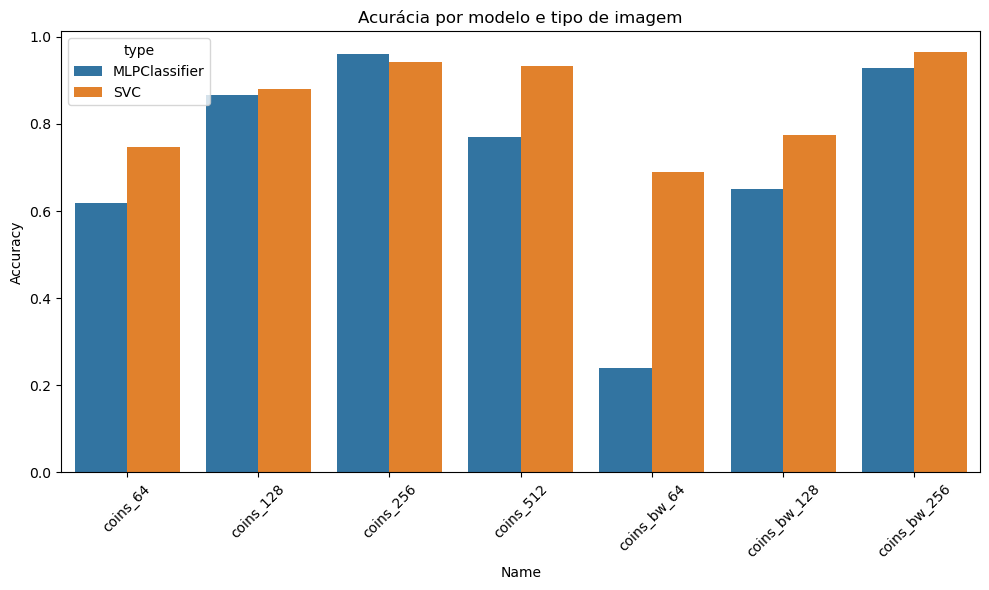

In [23]:
# Mostra as medidas de avaliação dos classificadores conforme o tipo e tamanho de imagem
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='accuracy', hue='type', data=results)
plt.title('Acurácia por modelo e tipo de imagem')
plt.ylabel('Accuracy')
plt.xlabel('Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
# Realiza um teste com uma imagem
model = models['coinsData_256']

clf = model.classifierMLP
image = cv2.imread('coin_images/eval/test_3.jpg')

model.imageProcessor.detect_coins(image, clf)